## 인프런 2020년 새해 다짐 이벤트 댓글 분석
* https://www.inflearn.com/pages/newyear-event-20200102
* 영상 튜토리얼 : [댓글 수백 수천개 분석하기?! [1/5] 이벤트 데이터 크롤링 feat. 인프런 새해 다짐 이벤트 - YouTube](https://www.youtube.com/watch?v=OUSwQk79H8I&list=PLaTc2c6yEwmohRzCxWQqJ7Z9aqc-sQ5gC)

## 기획자나 마케터가 되어 이벤트 댓글을 분석해 보자!
### 내가 만약 수백 수천개의 댓글을 다 읽어봐야 한다면?
### 댓글 속에 제품에 대한 관심을 빈도수로 추출해야 한다면?
* 쇼핑몰에서 제품 관련 이벤트 진행시 어떤 제품을 고객이 선호하는지 알고 싶다면?
* 고객 DB와 연계할 수 있다면 이벤트 혹은 마케팅 세그먼트로 활용해 볼 수도 있지 않을까?

### 향후 마케팅이나 전략을 어떻게 세워야 할까?

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline
# 시각화 결과가 선명하게 표시되도록
%config InlineBackend.figure_format = 'retina'

## 시각화를 위한 한글폰트 설정

In [2]:
# Window 한글폰트 설정
# plt.rc("font", family="Malgun Gothic")
# Mac 한글폰트 설정
plt.rc("font", family="AppleGothic")
plt.rc('axes', unicode_minus=False)

## 크롤링한 파일 로드하기

In [3]:
# df 라는 변수에 이벤트 댓글 파일을 로드합니다.
df = pd.read_csv("inflearn-event.csv")
df.shape

(2449, 1)

In [4]:
# head 로 미리보기 합니다.
df.head()

,text
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
1,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는..."
2,2020년 목표 : 리액트 공부하기
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!


In [5]:
# tail 로 미리보기 합니다.
df.tail()

,text
2444,"작년 한해도 일이 바쁘다, 야근해서 힘들다는 핑계로 김영한님의 JPA 강의를 또 스..."
2445,저는 졸업을 1년 남기고 있는 컴퓨터공학과 학생입니다. 졸업 프로젝트로 웹/앱 개발...
2446,"에프터 이펙트를 써본 적은 있는데, 매번 기초만 배우다 말았어요. 이걸 할 줄 안다..."
2447,저번에 인프런에서 페이스북 마케팅 강의를 듣고 많은 도움을 받았습니다. 마케팅 업무...
2448,인프런 0호 팀원이에요!\n그동안 서비스 개발 때문에 js 를 많이 했었는데 앞으론...


## 데이터 전처리

### 네트워크 오류 등으로 발생한 중복 입력 값을 제거
* 빈도 수 중복을 방지하기 위해

In [6]:
# drop_duplicates 를 통해 중복을 제거합니다. 이때 마지막 글을 남깁니다.
print(df.shape)
df = df.drop_duplicates(["text"], keep="last")
print(df.shape)

(2449, 1)
(2411, 1)


### 원본은 따로 보존

In [7]:
# 전처리 전에 원본을 보존하기 위해 origin_text 라는 컬럼에 복사해 둡니다.
df["origin_text"] = df["text"]
df.head()

,text,origin_text
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
1,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는...","2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는..."
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!
5,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!


### 소문자 변환

In [8]:
# "text" 파이썬은 대소문자를 구분하기 때문에 데이터 필터링을 위해 대문자를 모두 소문자로 변경
df["text"] = df["text"].str.lower()

In [9]:
# 같은 의미의 단어를 하나로 통일 예) python => 파이썬
# replace 는 텍스트가 완전히 일치될 때만 사용할 수 있습니다.
# 일부만 일치한다면 str.replace 를 사용하면 원하는 텍스트로 변경이 가능합니다.
df["text"] = df["text"].str.replace(
    "python", "파이썬").str.replace(
    "pandas", "판다스").str.replace(
    "javascript", "자바스크립트").str.replace(
    "java", "자바").str.replace(
    "react", "리액트")

### 텍스트로 관심 강의 분리

In [10]:
# 이 이벤트에는 "관심강의"라는 텍스트가 있습니다.
# "관심강의"를 기준으로 텍스트를 분리하고 관심강의 뒤에 있는 텍스트를 가져옵니다.
# 대부분 "관심강의"라는 텍스트를 쓰고 뒤에 강의명을 쓰기 때문입니다.
# 전처리한 내용은 실수를 방지하기 위해 "course" 라는 새로운 컬럼에 담습니다.
# "관심 강의", "관심 강좌" 에 대해서도 똑같이 전처리 합니다.
# ":" 특수문자를 빈문자로 바꿔줍니다.

df["course"] = df["text"].apply(lambda x: x.split("관심강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강좌")[-1])
df["course"] = df["course"].str.replace(":", "")
df["course"].head()

0    2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...
1    2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ...
3                  40대 프로그래밍 시작!  우리를 위한 프로그래밍  파이썬 중급
4                       2020년 목표  돌머리 비전공자가 멋진 전공자 되기!
5                     2020 년목표 비전공자(경영)가 전공자(it) 되기!!!
Name: course, dtype: object

In [11]:
# "text", "course" 전처리 내용 미리보기
df[["text", "course"]].head()

,text,course
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...
1,"2020년 목표: c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는...","2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ..."
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 돌머리 비전공자가 멋진 전공자 되기!
5,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표 비전공자(경영)가 전공자(it) 되기!!!


## 띄어 쓰기를 제거한 텍스트에서 키워드 추출
* TIOBE 프로그래밍 언어 순위 : [index | TIOBE - The Software Quality Company](https://www.tiobe.com/tiobe-index/?fbclid=IwAR34dJfgDHq2DK0C6X3g8IsUno2NhOiikMyxT6fw9SoyujFhy5FPvQogMoA)

In [12]:
# 특정 키워드가 들어가는 댓글을 찾습니다.
search_keyword = ['머신러닝', '딥러닝', '파이썬', '판다스', '공공데이터',
                  'django', '크롤링', '시각화', '데이터분석', 
                  '웹개발', '엑셀', 'c', '자바', '자바스크립트', 
                  'node', 'vue', '리액트']

# for 문을 통해 해당 키워드가 있는지 여부를 True, False값으로 표시하도록 합니다.
# 키워드에 따라 컬럼을 새로 만듭니다.
for keyword in search_keyword:
    df[keyword] = df["course"].str.contains(keyword)

In [13]:
# 미리보기 합니다.
df.head()

,text,origin_text,course,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,"2020년 목표: c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는...","2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는...","2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 돌머리 비전공자가 멋진 전공자 되기!,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표 비전공자(경영)가 전공자(it) 되기!!!,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [14]:
# 파이썬|공공데이터|판다스 라는 텍스트가 들어가는 데이터가 있는지 찾습니다.
df_python = df[df["text"].str.contains("파이썬|공공데이터|판다스")].copy()
df_python.shape

(430, 20)

In [15]:
# 결과를 모두 더하면 해당 키워드의 등장 빈도수를 카운트 할 수 있습니다.
# search_keyword 컬럼만 가져와서 빈도수를 sum으로 더합니다.
df[search_keyword].sum().sort_values(ascending=False)

c         410
파이썬       406
자바        341
자바스크립트    140
리액트       137
머신러닝      133
vue       132
node      117
크롤링        56
딥러닝        53
django     31
시각화        30
웹개발        27
데이터분석      24
엑셀         18
공공데이터      12
판다스         6
dtype: int64

In [16]:
# 공공데이터 텍스트가 들어가는 문장만 찾습니다.
# pandas 를 통해 볼때 문장이 길면 끝까지 보이지 않습니다.
# 문장의 전체를 보기 위해 for문을 통해 해당 텍스트를 순회하며 출력합니다.
# 이 때, 데이터 사이에 ------ 줄로 구분해서 표시하도록 합니다.
text = df.loc[(df["공공데이터"] == True), "text"]
for t in text:
    print("-"*20)
    print(t)

--------------------
#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
파이썬의 고수가 되고싶어요
--------------------
자바기반 웹 개발자입니다. 데이터 분석에 많이 쓰이는 파이썬이 궁금합니다.
#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
올해 안에 원하는 공부 다 끝내보려고요. 내년이면 수능이라..

#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
it개발자입니다. 개발을 오래 안하고 관리만 했더니 다시 개발이 너무 하고싶습니다. 올해는 인프런을 통해서 개발쪽 스킬셋을 업그레이드 하고 싶습니다!
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
파이썬 데이터분석 마스터
#관심강의:공공데이터로 파이썬 데이터 분석 시작하기
--------------------
올해 졸업하는 컴퓨터공학과 학생입니다!
백엔드 혹은 데이터 엔지니어 쪽으로 취업하고 싶습니다!
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
텍스트 마이닝만 수강한 뒤 현재 맡은 마케팅 업무 능률이 엄청나게 올라가는 것을 확인했으며 승진과 고가에 엄청나게 득을 보았습니다 감사합니다! 앞으로도 인프런 애용하겠습니다.
추가적으로 해 박조은 강사님의 [공공데이터로 파이썬 데이터 분석 시작하기] 강의를 듣고 상권분석과 공공데이터 활용 역량을 올릴 예정입니다. 화이팅!!!
#관심강의 : 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
데이터분석 2년차가 되는데 작년에 파이썬 강의를 담아놓고 그대로 1년간 방치... 올해는 꼭 완강하고 실습해서 개발자에게 의존하지 않고 혼자 크롤링&분석 해내고 싶어요! 
#관심강의: 공공데이터로 파이썬 데이터분석 시작하기, database 1&2 - mysql
------

## 판다스 단어가 들어가는 텍스트만 찾기
* 이미 str.contains 를 통해 판다스가 들어가는 텍스트에 대해 컬럼을 만들어 놨습니다. 이 값이  True 라면 판다스 강좌 입니다.

In [17]:
# pandas 라는 텍스트가 들어가는 내용만 찾습니다.

df.loc[df["판다스"] == True, "text"]

541     2020년에는 데이터분석 관련한 실력을 쌓고싶습니다!\n#관심강의 : 파이썬, 판다...
690     취미로 안드로이드 개발하는 사람입니다. 자바로 작성하다 보니, kotlin이 안드로...
758          판다스 라입러리에 관심이 많아서 배워보려 합니다 #관심강의 : 박조은 - 판다스
1237      2020년!! 올 해는 빅데이터 분석 전문가 되기!!\n#관심강의 : 파이썬, 판다스
2155    2020년 목표  파이썬 을  활용해  데이터 분석 작업을 진행하고 싶습니다.  관...
2365    저는 백세시대에 조금 더 오랫동안 it일을 하기위해서 it전략기획에서 데이터분석가로...
Name: text, dtype: object

## 빈도수 계산을 위한 텍스트 데이터 벡터화
* BOW 단어 가방에 단어를 토큰화 해서 담아줌

In [18]:
# "파이썬 데이터 분석" 이라는 텍스트를 토큰화 split 을 통해 해봅니다.
"파이썬 데이터 분석".split()

['파이썬', '데이터', '분석']

In [19]:
# 사이킷런의 CountVectorizer 를 통해 벡터화 합니다.
# vectorizer 라는 변수에 CountVectorizer 를 담습니다.
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
                             ngram_range=(3, 6), # BOW의 단위 갯수의 범위를 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=2,
                ngram_range=(3, 6), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [20]:
# df['course'] 만 벡터화 합니다.
feature_vector = vectorizer.fit_transform(df['course'])
feature_vector.shape

(2411, 2000)

In [21]:
# vectorizer 에서 get_feature_names 를 추출합니다.
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['12개 만들면서 배우는',
 '12개 만들면서 배우는 ios',
 '12개 만들면서 배우는 ios 아이폰',
 '12개 만들면서 배우는 ios 아이폰 개발',
 '12개를 만들며 배우는',
 '12개를 만들며 배우는 swift4',
 '12개를 만들며 배우는 swift4 ios11',
 '12개를 만들며 배우는 swift4 ios11 아이폰',
 '2018 do it',
 '2018 do it 안드로이드']

In [22]:
# 각 리뷰마다 등장하는 단어에 빈도수가 표현됩니다. 0 은 등장하지 않음을 의미합니다.
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head()

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# 위에서 구한 단어벡터를 더하면 단어가 전체에서 등장하는 횟수를 알 수 있습니다.
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)
    
df_freq = pd.DataFrame(dist, columns=vocab)
df_freq

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,2,2,2,2,2,2,2,2,2,2,...,16,13,13,12,2,8,8,2,2,2


In [24]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬합니다.
df_freq.T.sort_values(by=0, ascending=False).head(30)

,0
홍정모의 따라하며 배우는,100
스프링 데이터 jpa,60
nodebird sns 만들기,60
파이썬 머신러닝 완벽,49
리액트로 nodebird sns,49
머신러닝 완벽 가이드,49
리액트로 nodebird sns 만들기,49
파이썬 머신러닝 완벽 가이드,48
프로그래밍과 자바스크립트 es6,48
함수형 프로그래밍과 자바스크립트 es6,47


In [25]:
# ["course", "freq"] 라는 컬럼명을 주어 위에서 만든 데이터프레임을 변환합니다.
df_freq_T = df_freq.T.reset_index()
df_freq_T.columns = ["course", "freq"]
df_freq_T.head()

,course,freq
0,12개 만들면서 배우는,2
1,12개 만들면서 배우는 ios,2
2,12개 만들면서 배우는 ios 아이폰,2
3,12개 만들면서 배우는 ios 아이폰 개발,2
4,12개를 만들며 배우는,2


In [26]:
# 강의명을 토큰 3개로 중복제거하기 위해, 강좌명에서 지식공유자의 이름을 빈문자열로 변경합니다.
# 강의명을 lambda 식을 사용해서 x.split() 으로 나누고 [:4] 앞에서 4개까지만 텍스트를 가져오고 다시 join으로 합쳐줍니다. 
# 중복된 텍스트를 구분해서 보기 위함입니다.
df_freq_T["course_find"] = df_freq_T["course"].str.replace("홍정모의", "")
df_freq_T["course_find"] = df_freq_T["course_find"].apply(lambda x : " ". join(x.split()[:4]))
df_freq_T.sort_values(["course_find", "freq"], ascending=False).head(10)

,course,freq,course_find
1999,활용한 파이썬 프로그래밍,2,활용한 파이썬 프로그래밍
1998,활용한 메신져 만들기 android,2,활용한 메신져 만들기 android
1997,활용한 메신져 만들기,2,활용한 메신져 만들기
1996,활용한 리액트 native 개발,8,활용한 리액트 native 개발
1995,활용한 리액트 native,8,활용한 리액트 native
1994,활용한 데이터분석과 it보안,2,활용한 데이터분석과 it보안
1992,활용한 다양한 자동화 어플리케이션,13,활용한 다양한 자동화 어플리케이션
1993,활용한 다양한 자동화 어플리케이션 제작하기,12,활용한 다양한 자동화 어플리케이션
1991,활용한 다양한 자동화,13,활용한 다양한 자동화
1989,활용2 api 개발과 성능,16,활용2 api 개발과 성능


In [27]:
# 3개의 ngram과 빈도수로 역순 정렬을 하게 되면 빈도수가 높고, ngram수가 많은 순으로 정렬이 됨 
# 여기에서 drop_duplicates로 첫 번째 강좌를 남기고 나머지 중복을 삭제 합니다.
print(df_freq_T.shape)
df_course = df_freq_T.drop_duplicates(["course_find", "freq"], keep="first")
print(df_course.shape)

(2000, 3)
(1441, 3)


In [28]:
# 빈도수로 정렬을 하고 어떤 강좌가 댓글에서 가장 많이 언급되었는지 봅니다.
df_course = df_course.sort_values(by="freq", ascending=False)
df_course.head(20)

,course,freq,course_find
1965,홍정모의 따라하며 배우는,100,따라하며 배우는
1083,스프링 데이터 jpa,60,스프링 데이터 jpa
324,nodebird sns 만들기,60,nodebird sns 만들기
912,리액트로 nodebird sns 만들기,49,리액트로 nodebird sns 만들기
1737,파이썬 머신러닝 완벽,49,파이썬 머신러닝 완벽
911,리액트로 nodebird sns,49,리액트로 nodebird sns
933,머신러닝 완벽 가이드,49,머신러닝 완벽 가이드
1738,파이썬 머신러닝 완벽 가이드,48,파이썬 머신러닝 완벽 가이드
1868,프로그래밍과 자바스크립트 es6,48,프로그래밍과 자바스크립트 es6
1918,함수형 프로그래밍과 자바스크립트 es6,47,함수형 프로그래밍과 자바스크립트 es6


In [29]:
# 전처리가 다 되었다면 다른 팀 또는 담당자에게 전달하기 위해  csv 형태로 저장합니다.
df_course.to_csv("event-course-name-freq.csv")

## TF-IDF 로 가중치를 주어 벡터화
### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정합니다.
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값(유클리디안거리)
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절(맨하탄거리)
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

In [30]:
# TfidfTransformer 를 불러와서 가중치를 주어 벡터화 합니다.
# transformer 라는 변수로 저장하고 재사용합니다.
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [31]:
# fit_transform 으로 가중치를 적용하고 결과를 feature_tfidf 로 받습니다.
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

(2411, 2000)

In [32]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector에 TF-IDF 가중치 반영한 결과를 봅니다.
# feature_tfidf.toarray() 로 배열로 만들고  데이터 프레임을 만들어 tfidf_freq 라는 변수에 할당해서 봅니다.
tfidf_freq = pd.DataFrame(feature_tfidf.toarray(), columns=vocab)
tfidf_freq.head() 

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# tfidf_freq를 sum 으로 가중치를 다 더해줍니다.
df_tfidf = pd.DataFrame(tfidf_freq.sum())
df_tfidf_top = df_tfidf.sort_values(by=0, ascending=False)
df_tfidf_top.head(10)

,0
홍정모의 따라하며 배우는,66.601666
스프링 데이터 jpa,35.647452
nodebird sns 만들기,26.975433
파이썬 머신러닝 완벽,24.812491
머신러닝 완벽 가이드,24.564762
리액트로 nodebird sns,24.349249
리액트로 nodebird sns 만들기,24.349249
파이썬 머신러닝 완벽 가이드,23.912776
프로그래밍과 자바스크립트 es6,19.511837
함수형 프로그래밍과 자바스크립트,18.596891


In [34]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
for t in df_tfidf_top.index[:30]:
    print(t)

홍정모의 따라하며 배우는
스프링 데이터 jpa
nodebird sns 만들기
파이썬 머신러닝 완벽
머신러닝 완벽 가이드
리액트로 nodebird sns
리액트로 nodebird sns 만들기
파이썬 머신러닝 완벽 가이드
프로그래밍과 자바스크립트 es6
함수형 프로그래밍과 자바스크립트
함수형 프로그래밍과 자바스크립트 es6
부트 개념과 활용
스프링 부트 개념과
스프링 부트 개념과 활용
2020년 공부 목표
실전 스프링 데이터
실전 스프링 데이터 jpa
파이썬 실전 100
파이썬 실전 100 활용
남박사의 파이썬 실전
남박사의 파이썬 실전 100
실전 100 활용
남박사의 파이썬 실전 100 활용
관심있는 인프런 강의명
파이썬 머신러닝 완벽가이드
따라하며 배우는 c언어
홍정모의 따라하며 배우는 c언어
rest api 개발
대세는 쿠버네티스 기초편
스프링부트 개념과 활용


## 군집화 
* 실루엣 분석추가 https://www.kaggle.com/fabiendaniel/customer-segmentation
### KMeans

In [35]:
from sklearn.cluster import KMeans
from tqdm import trange
inertia = []

start = 30
end = 70

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# 학습을 할 때는 feature_tfidf 값을 사용합니다.
# cls.inertia_ 값을 inertia 리스트에 저장합니다.
for i in trange(start, end):
    cls = KMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    inertia.append(cls.inertia_)

100%|██████████| 40/40 [00:57<00:00,  1.43s/it]


Text(0.5, 1.0, 'KMeans 클러스터 수 비교')

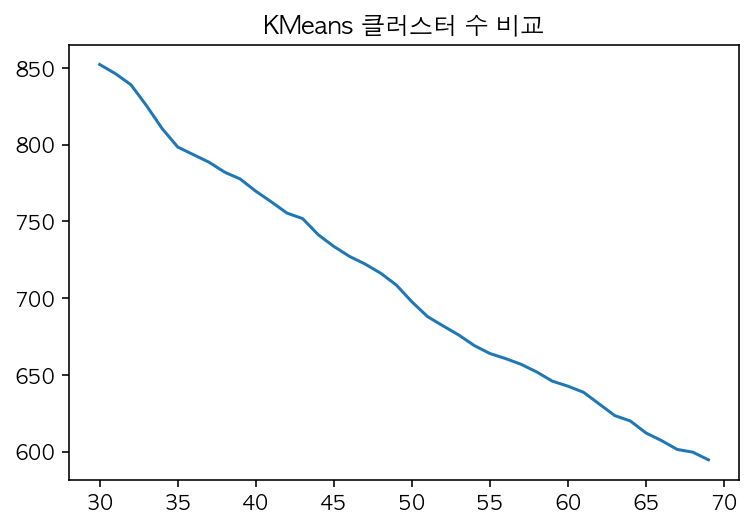

In [36]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 inertia 값을 넣어 그립니다.

plt.plot(range(start, end), inertia)
plt.title("KMeans 클러스터 수 비교")

* 적정한 클러스터 갯수를 넣어 군집화 합니다.

In [37]:
# n_clusters 에 적절한 값을 넣어줍니다.
# fit.predict 를 하고 결과를 cluster 라는 새로운 컬럼에 담습니다.
n_clusters = 50
cls = KMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["cluster"] = prediction

In [38]:
# 클러스터 센터
cc = cls.cluster_centers_

In [39]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(feature_tfidf)
X_tsne.shape

(2411, 2)

In [40]:
df2d = pd.DataFrame(X_tsne, columns=['x', 'y'])
df2d.shape

(2411, 2)

In [41]:
df2d["cluster"] = prediction
df2d.head()

,x,y,cluster
0,-5.862797,-6.373523,1
1,16.416540,15.865916,1
2,-12.115876,28.559704,1
3,14.890767,8.438693,1
4,3.379513,-4.475496,1


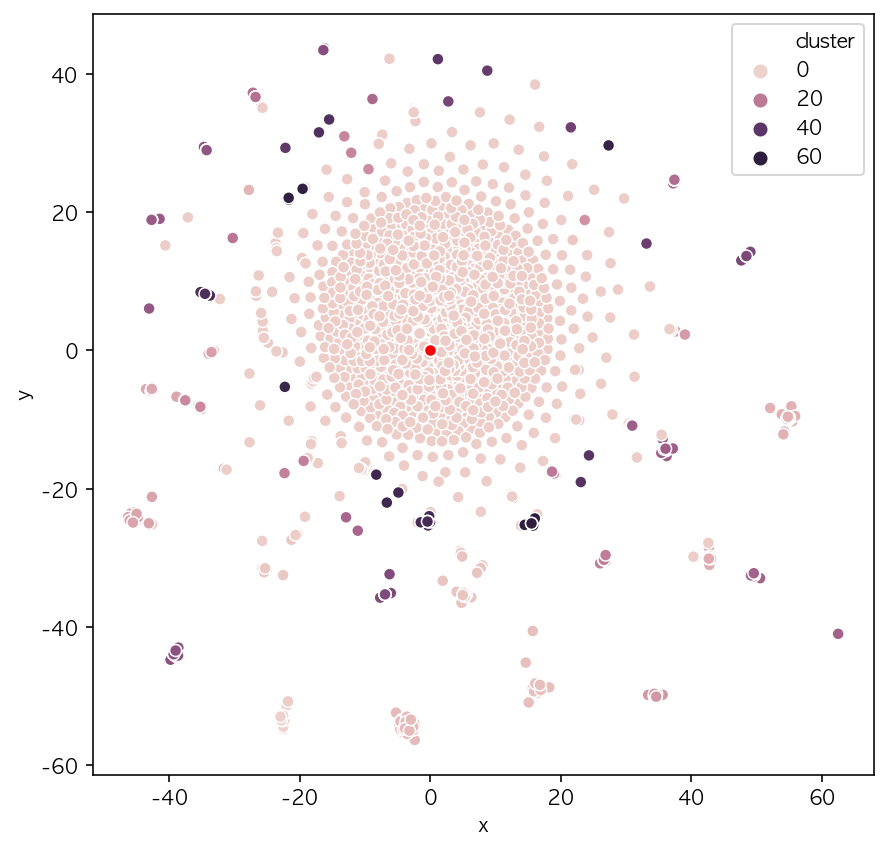

In [43]:
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df2d, x="x", y="y", hue="cluster")
sns.scatterplot(cc[:, 0], cc[:, 1],  color='red')

In [44]:
# df["cluster"] 의 빈도수를 value_counts로 세어봅니다.
df["cluster"].value_counts().head(10)

1     1663
5       54
4       43
10      42
3       37
7       32
0       29
2       28
31      28
27      25
Name: cluster, dtype: int64

### MiniBatchKMeans
* [Comparison of the K-Means and MiniBatchKMeans clustering algorithms — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

In [45]:
# batch_size 를 쓸 수 있는 MiniBatchKMeans 로 군집화
from sklearn.cluster import MiniBatchKMeans
b_inertia = []

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# b_inertia 리스트에 cls.inertia_ 값을 넣어줍니다.
for i in trange(start, end):
    cls = MiniBatchKMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    b_inertia.append(cls.inertia_)

100%|██████████| 40/40 [00:07<00:00,  5.67it/s]


Text(0.5, 1.0, 'MiniBatchKMeans 클러스터 수 비교')

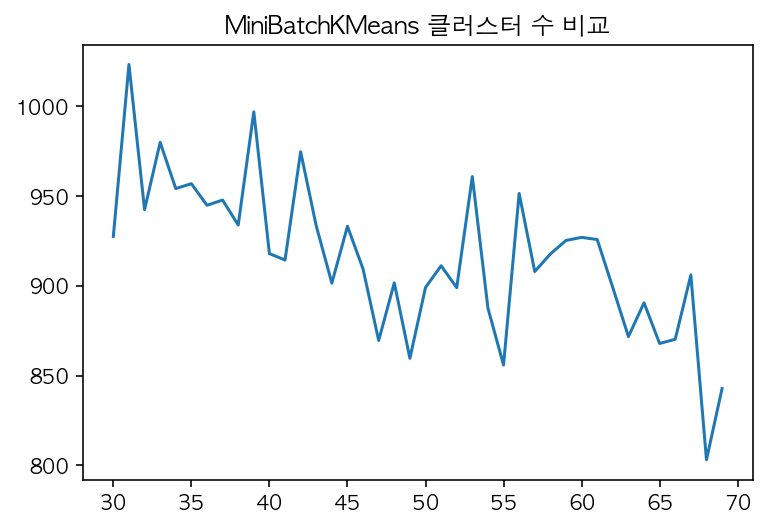

In [46]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 b_inertia 값을 넣어 그립니다.
plt.plot(range(start, end), b_inertia)
plt.title("MiniBatchKMeans 클러스터 수 비교")

In [47]:
# MiniBatchKMeans 를 통해 학습을 시킵니다.
# 결과를 bcluster 라는 변수에 저장합니다.
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["bcluster"] = prediction

In [48]:
# bcluster의 빈도수를 구합니다.
df["bcluster"].value_counts().head(10)

45    1123
1      401
24      69
23      54
25      47
5       42
32      42
38      41
12      36
18      35
Name: bcluster, dtype: int64

In [49]:
# 어떤 강좌명이 있는지 특정 클러스터의 값을 봅니다.  
df.loc[df["bcluster"] == 21, "course"].value_counts().head(1)

  자바스크립트로 알아보는 함수형 프로그래밍    2
Name: course, dtype: int64

In [50]:
# bcluster, cluster, course 값을 미리보기 합니다.
df.loc[df["bcluster"] == 21, ["bcluster", "cluster", "course"]]

,bcluster,cluster,course
432,21,1,자바스크립트로 알아보는 함수형 프로그래밍
468,21,1,; 자바스크립트로 알아보는 함수형 프로그래밍
973,21,1,자바스크립트로 알아보는 함수형 프로그래밍


In [51]:
df.loc[df["bcluster"] == 24, ["bcluster", "cluster", "origin_text", "course"]].tail(10)

,bcluster,cluster,origin_text,course
2073,24,1,대학을 와서 약 4년넘게 프로젝트를 제대로 해본적이 없는데 \n올해의 꼭 저만의 웹...,"r로 하는 웹 크롤링 - 실전편,r로 하는 웹 크롤링 - 입문편, 스프링 부트 개념..."
2139,24,1,2020년 목표: 조금 더 노력해서 하드한 ios 개발자 되기. 제발!!!\n관심 ...,ios 개발을 위한 swift5 완벽 가이드
2187,24,1,Vue.js 잘 배워서 프로젝트 마무리하고 풀스택 개발자가 되어 올해에는 꼭 취뽀하...,vue.js 중급 강좌
2196,24,21,javascript 프레임워크 공부 하고 싶어요! \n#관심강의 : Vue.js 시...,vue.js 시작하기 - age of vue.js
2264,24,41,"4년차 개발자 입니다. fullStack 개발에 관심있어\n시간내서 ""내 손으로 ...",내 손으로 만드는 django 2.x 인스타그램 클론 강의
2266,24,41,프론트앱과 백엔드를 같이 공부하고싶은 고등학생입니다 새해다짐으로 1개월만에 웹서비스...,"내 손으로 만드는 django 2.x 인스타그램 클론 강의,코알못에서 웹서비스 런칭..."
2385,24,21,프론트엔드 개발자로 취업 뽀개기! 취업뿌셔!\n# 관심강의: Vue.js 시작하기 ...,vue.js 시작하기 - age of vue.js
2398,24,1,2020년 공부목표:\n컴퓨터 공학을 전공하지 않았지만 소프트웨어 개발자로 일하고 ...,2020년 공부목표\n컴퓨터 공학을 전공하지 않았지만 소프트웨어 개발자로 일하고 있...
2419,24,1,2020년 공부목표: \n학교를 졸업한지 벌써 3년입니다. 졸업 할 때 만해도 무엇...,2020년 공부목표 \n학교를 졸업한지 벌써 3년입니다. 졸업 할 때 만해도 무엇이...
2427,24,40,"마음으로는 모든 강의가 듣고싶지만, 한가지씩 해나가고싶습니다. 우선은 파이썬부터 시...",파이썬 사용자를 위한 웹개발 입문 a to z django + bootstrap


### 클러스터 예측 정확도 확인하기

In [52]:
# n_clusters 위에서 정의한 클러스터 수를 사용
feature_array = feature_vector.toarray()
# 예측한 클러스터의 유니크 값
labels = np.unique(prediction)
df_cluster_score = []
df_cluster = []
for label in labels:
    id_temp = np.where(prediction==label) # 예측한 값이 클러스터 번호와 매치 되는 것을 가져옴
    x_means = np.mean(feature_array[id_temp], axis = 0) # 클러스터의 평균 값을 구함
    sorted_means = np.argsort(x_means)[::-1][:n_clusters] # 값을 역순으로 정렬해서 클러스터 수 만큼 가져옴
    features = vectorizer.get_feature_names()
    best_features = [(features[i], x_means[i]) for i in sorted_means] 
    # 클러스터별 전체 스코어
    df_score = pd.DataFrame(best_features, columns = ['features', 'score'])
    df_cluster_score.append(df_score)
    # 클러스터 대표 키워드
    df_cluster.append(best_features[0])

In [53]:
# 개별 클러스터에서 점수가 가장 높은 단어를 추출 아래 점수가 클수록 예측 정확도가 높음
# MiniBatchKMeans 로 예측한 값 기준
pd.DataFrame(df_cluster, columns = ['features', 'score']).sort_values(by=["features", "score"], ascending=False)

,features,score
16,홍정모의 따라하며 배우는 c언어,1.000000
23,홍정모의 따라하며 배우는,1.000000
33,홍정모의 따라하며 배우는,1.000000
1,프로그래밍과 자바스크립트 es6,0.109726
32,프로그래밍 입문 강좌 renew ver 초보부터,1.000000
25,프로그래밍 시작하기 파이썬 입문,0.382979
13,파이썬 입문 크롤링을 활용한 다양한,0.419355
3,파이썬 머신러닝 완벽,1.000000
11,취업을 위해 제대로,0.333333
36,초심자를 위한 리액트,1.000000


In [54]:
# score 정확도가 1이 나온 클러스터를 찾아봄 - 같은 강좌끼리 묶였는지 확인 함
df.loc[df["bcluster"] == 28, ["bcluster", "cluster", "origin_text", "course"]]

,bcluster,cluster,origin_text,course
28,28,1,메카트로닉스공학과를 나와 이제 취직을 준비하는 취준생입니다. \n 취직을 준비하면서...,1. 홍정모의 따라하며 배우는 c++\n ...
152,28,1,2020년에는 비전공자이지만 인프런의 풍부한 교육 리소스로 개발분야의 역량을 키워서...,2020년에는 비전공자이지만 인프런의 풍부한 교육 리소스로 개발분야의 역량을 키워서...
385,28,1,정말이지 올해에는 개발에 대한 전체적이고 안정적으로 들어가고싶어요 ㅠㅠ\n#관심강의...,해외취업 asp.net core 웹개발 기본 강좌
443,28,1,프로그래밍 배우는 걸 계속 미루고 있어서 이제부터라도 시작하고자 차근차근 배우려고 ...,'파이썬 기본부터 인공지능 머신러닝까지' 학습 로드맵
451,28,1,의학관련 연구를 하는데 최근 빅데이터 관련 머신러닝이 필요한 자료 분석이 생겼습니다...,'파이썬 기본부터 인공지능 머신러닝까지' 학습 로드맵
454,28,1,리눅스에 대해 더 깊이 공부하고 싶어요!\n#관심강의 : 리눅스 시스템 프로그래밍 ...,리눅스 시스템 프로그래밍 - 이론과 실습
475,28,1,올해는 it회사에 꼭 취직하고 싶습니다!!\n스프링 프레임워크를 중점적으로 공부할 ...,올해는 it회사에 꼭 취직하고 싶습니다!!\n스프링 프레임워크를 중점적으로 공부할 ...
590,28,1,올해 자격증 웹디자인기능사를 딸 예정인데\n그 전에 이 강의(공도리의HTML5와 C...,올해 자격증 웹디자인기능사를 딸 예정인데\n그 전에 이 강의(공도리의html5와 c...
747,28,1,- 올해 목표 : 대학에서 컴퓨터 공학을 전공하고 IT 기술을 인간에게 이롭게 활용...,'파이썬 기본부터 인공지능 머신러닝까지' 학습 로드맵
840,28,1,임베디드 시스템 프로그래머로 성장하기위해 노력하려고 합니다.\n#관심강의:리눅스 시...,리눅스 시스템 프로그래밍


## WordCloud
* [amueller/word_cloud: A little word cloud generator in Python](https://github.com/amueller/word_cloud)
* 설치 방법 : [Wordcloud :: Anaconda Cloud](https://anaconda.org/conda-forge/wordcloud)

In [55]:
# 불용어 - 자주 등장하지만 의미가 크지 않아 제외하고 싶은 텍스트
# stopwords = ["관심 강의", "관심강의", "관심", "강의", "강좌", "강의를",
#              "올해", "올해는", "열심히", "공부를", "합니다", "하고", "싶어요", 
#              "있는", "있습니다", "싶습니다", "2020년"]
# 불용어를 제거하지 않고 그리려면 아래 주석을 풀어서 stopword 변수에 덮어쓰기를 합니다.
stopwords = []
# displayWordCloud 라는 함수를 만들어 재사용합니다.
from wordcloud import WordCloud


def displayWordCloud(data = None, backgroundcolor = 'black', width=1280, height=768):
    wordcloud = WordCloud(
                        font_path = '/Library/Fonts/NanumBarunGothic.ttf', 
                        stopwords = stopwords, 
                        background_color = backgroundcolor, 
                        width = width, height = height, 
                        random_state=42).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

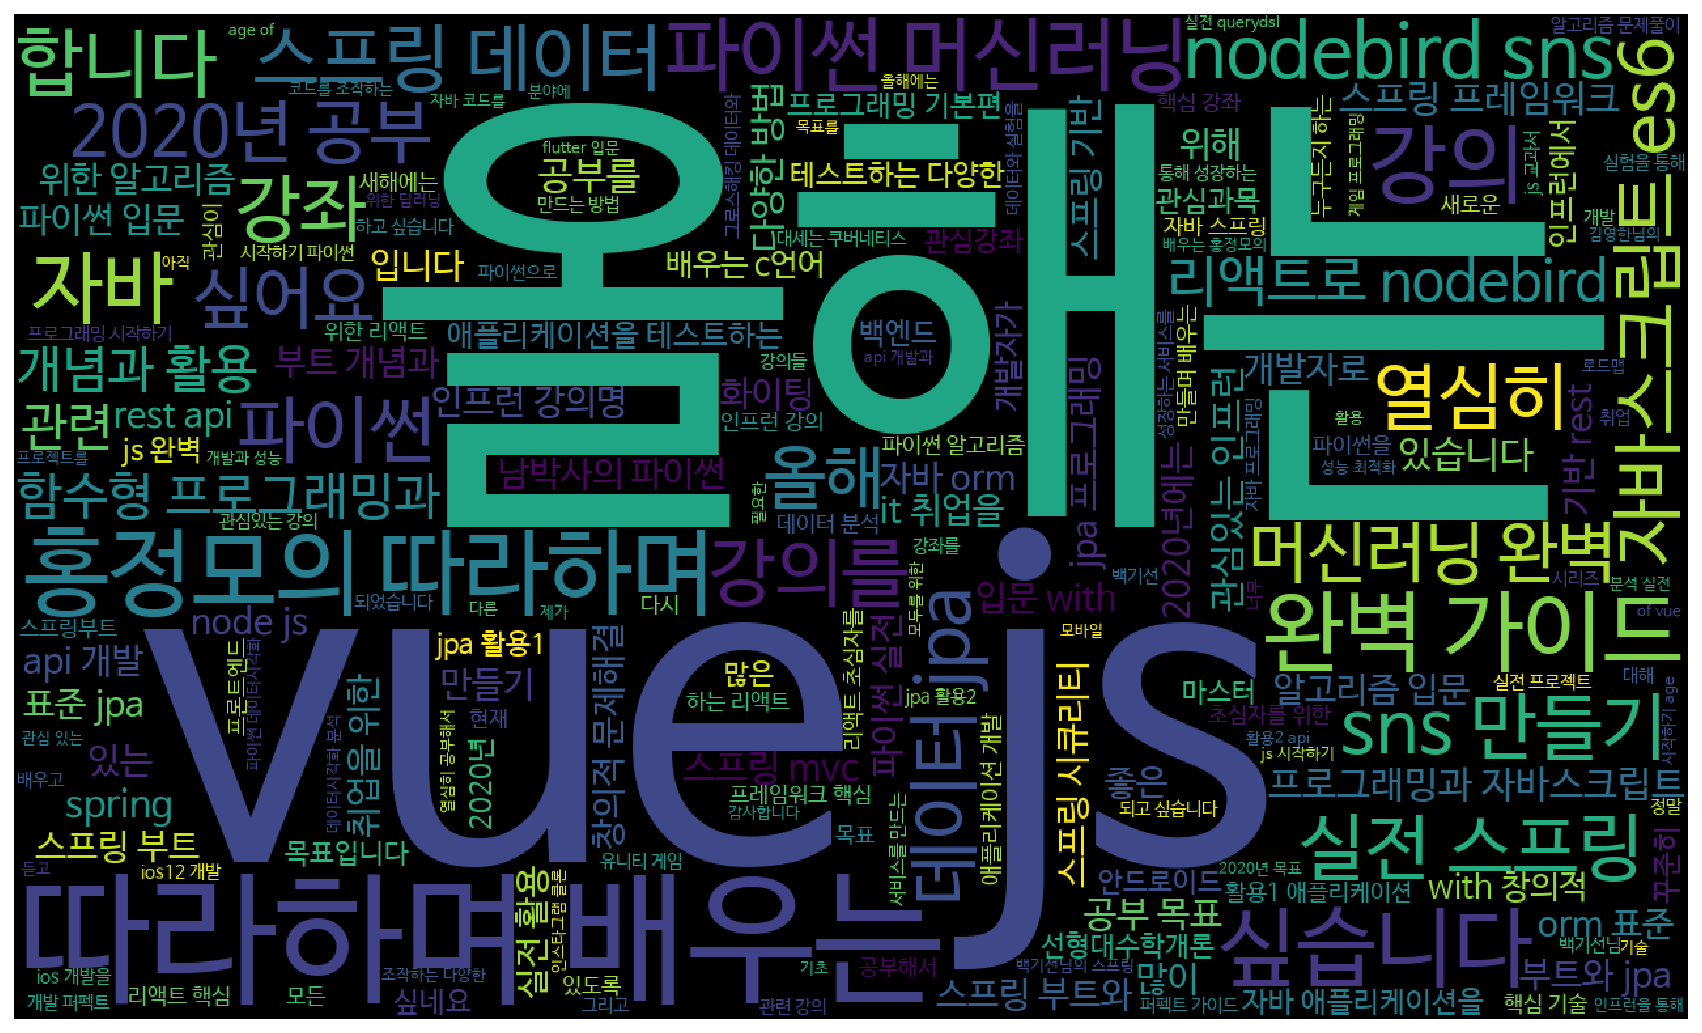

In [56]:
course_text = " ".join(df["course"])
displayWordCloud(course_text)